In [1]:
import json
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from random import shuffle, choices
import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    hamming_loss,
)

/Users/ewenmichel/miniconda3/envs/altegrad/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from GRU_pipeline import DataHolder, paths, MultiModalDicDataset, GRUModel, pad_collate
from models import GRUMultiModal

DH = DataHolder(**paths, none_as_class=True)

train_test_1 = DH.stratified_train_test_split(feature = 'multimodal', speaker = 1, none_count = 2000, test_size = .15, val_size = .17)
train_test_2 = DH.stratified_train_test_split(feature = 'multimodal', speaker = 2, none_count = 2000, test_size = .15, val_size = .17)

class_weights = train_test_1['class_weights']
class_weights = torch.Tensor([(1 - x) ** 5 for x in class_weights])

In [3]:
train_dataset_1 = MultiModalDicDataset(**train_test_1['data'])
test_dataset_1 = MultiModalDicDataset(train_dic_openface = train_test_1["data"]["test_dic_openface"], train_dic_opensmile = train_test_1["data"]["train_dic_opensmile"], features_openface = train_test_1["data"]["features_openface"], features_opensmile = train_test_1["data"]["features_opensmile"], embeds = train_test_1["data"]["embeds"], targets = train_test_1["data"]["targets"], test_dic_openface = None, test_dic_opensmile = None)
val_dataset_1 = MultiModalDicDataset(train_dic_openface = train_test_1["data"]["valid_dic_openface"], train_dic_opensmile = train_test_1["data"]["valid_dic_opensmile"], features_openface = train_test_1["data"]["features_openface"], features_opensmile = train_test_1["data"]["features_opensmile"], embeds = train_test_1["data"]["embeds"], targets = train_test_1["data"]["targets"], test_dic_openface = None, test_dic_opensmile = None)

train_loader_1 = DataLoader(train_dataset_1, batch_size = 200, shuffle = True, collate_fn = pad_collate)
val_loader_1 = DataLoader(val_dataset_1, batch_size = 200, shuffle = True, collate_fn = pad_collate)
test_loader_1 = DataLoader(test_dataset_1, batch_size = 200, shuffle = True, collate_fn = pad_collate)

train_dataset_2 = MultiModalDicDataset(**train_test_2['data'])
test_dataset_2 = MultiModalDicDataset(train_dic_openface = train_test_2["data"]["test_dic_openface"], train_dic_opensmile = train_test_2["data"]["train_dic_opensmile"], features_openface = train_test_2["data"]["features_openface"], features_opensmile = train_test_2["data"]["features_opensmile"], embeds = train_test_2["data"]["embeds"], targets = train_test_2["data"]["targets"], test_dic_openface = None, test_dic_opensmile = None)
val_dataset_2 = MultiModalDicDataset(train_dic_openface = train_test_2["data"]["valid_dic_openface"], train_dic_opensmile = train_test_2["data"]["valid_dic_opensmile"], features_openface = train_test_2["data"]["features_openface"], features_opensmile = train_test_2["data"]["features_opensmile"], embeds = train_test_2["data"]["embeds"], targets = train_test_2["data"]["targets"], test_dic_openface = None, test_dic_opensmile = None)

train_loader_2 = DataLoader(train_dataset_2, batch_size = 200, shuffle = True, collate_fn = pad_collate)
val_loader_2 = DataLoader(val_dataset_2, batch_size = 200, shuffle = True, collate_fn = pad_collate)
test_loader_2 = DataLoader(test_dataset_2, batch_size = 200, shuffle = True, collate_fn = pad_collate)

In [4]:
def eval_on_val():
    model.eval()
    tot_loss=0.0
    for i, batch in enumerate(val_loader_1):
        features_of, features_os, embeds, targets = batch['features_of'], batch['features_os'], batch['embeds'], batch['targets']
        with torch.no_grad():
            pred = model(embeds, features_os, features_of)
            loss = criterion(pred, targets)
            tot_loss += loss / pred.shape[0]
    for i, batch in enumerate(val_loader_2):
        features_of, features_os, embeds, targets = batch['features_of'], batch['features_os'], batch['embeds'], batch['targets']
        with torch.no_grad():
            pred = model(embeds, features_os, features_of)
            loss = criterion(pred, targets)
            tot_loss += loss / pred.shape[0]
    return (tot_loss / (len(val_loader_1) + len(val_loader_2)))

def train_one_epoch(epoch, dataloader_1, dataloader_2, hist_train_loss, hist_val_loss, stagnation):

    model.train(True)

    epoch_loss = 0.0
    best_vloss = 1000

    for i, batch in enumerate(dataloader_1):
        features_of, features_os, embeds, targets = batch['features_of'], batch['features_os'], batch['embeds'], batch['targets']
        pred = model(embeds, features_os, features_of)
        loss = criterion(pred, targets)

        epoch_loss += loss / pred.shape[0]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    for i, batch in enumerate(dataloader_2):
        features_of, features_os, embeds, targets = batch['features_of'], batch['features_os'], batch['embeds'], batch['targets']
        pred = model(embeds, features_os, features_of)
        loss = criterion(pred, targets)

        epoch_loss += loss / pred.shape[0]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = epoch_loss / (len(dataloader_1) + len(dataloader_2))
    hist_train_loss = hist_train_loss + [epoch_loss]
    model.train(False)
    val_loss = eval_on_val()
    hist_val_loss = hist_val_loss + [val_loss]
    if epoch % 30 == 0:
        print("EPOCH {}:".format(epoch + 1))
        tqdm.write(f"================\nTraining epoch {epoch} :\nTrain loss = {1000 * epoch_loss}, Val loss = {1000 * val_loss}\n================")
    if val_loss < best_vloss:
        best_vloss = val_loss
        torch.save(model.state_dict(), "models/GRU_concat_test")
        stagnation = 0
    return hist_train_loss, hist_val_loss, stagnation

In [5]:
model = GRUMultiModal(embeddings_dim = 768, audio_input_dim=23, audio_hidden_dim=16, audio_hidden_dim2=8, audio_layer_dim=3, video_input_dim=17, video_hidden_dim=16, video_hidden_dim2=10, video_layer_dim=3, output_dim=6, dropout_prob=.1)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = 5e-5)

EPOCHS = 300

hist_train_loss = []
hist_val_loss = []
device = torch.device("mps")
stagnation= 0

for epoch in tqdm(range(EPOCHS), total = EPOCHS):

    curr_train_loss, curr_val_loss = hist_train_loss, hist_val_loss
    if epoch % 30 == 0:
        print("EPOCH {}:".format(epoch + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    hist_train_loss, hist_val_loss, stagnation = train_one_epoch(
        epoch, train_loader_1, train_loader_2, hist_train_loss, hist_val_loss, stagnation
    )
    stagnation += 1

    if stagnation > 10:
        break
hist_train_loss = [x.detach().numpy() for x in hist_train_loss]
hist_val_loss = [x.detach().numpy() for x in hist_val_loss]

  0%|          | 0/300 [00:00<?, ?it/s]

EPOCH 1:


  0%|          | 1/300 [00:03<19:12,  3.86s/it]

EPOCH 1:
Training epoch 0 :
Train loss = 3.410562038421631, Val loss = 3.329970121383667


 10%|█         | 30/300 [01:43<15:04,  3.35s/it]

EPOCH 31:


 10%|█         | 31/300 [01:47<15:12,  3.39s/it]

EPOCH 31:
Training epoch 30 :
Train loss = 0.755124032497406, Val loss = 0.8371599912643433


 20%|██        | 60/300 [03:21<12:28,  3.12s/it]

EPOCH 61:


 20%|██        | 61/300 [03:24<12:19,  3.09s/it]

EPOCH 61:
Training epoch 60 :
Train loss = 0.3848642110824585, Val loss = 0.4478127956390381


 30%|███       | 90/300 [04:54<11:19,  3.24s/it]

EPOCH 91:


 30%|███       | 91/300 [04:57<11:27,  3.29s/it]

EPOCH 91:
Training epoch 90 :
Train loss = 0.2350315898656845, Val loss = 0.24834217131137848


 40%|████      | 120/300 [06:32<09:44,  3.25s/it]

EPOCH 121:


 40%|████      | 121/300 [06:35<09:46,  3.28s/it]

EPOCH 121:
Training epoch 120 :
Train loss = 0.17797636985778809, Val loss = 0.20616015791893005


 50%|█████     | 150/300 [08:06<09:18,  3.72s/it]

EPOCH 151:


 50%|█████     | 151/300 [08:10<09:23,  3.78s/it]

EPOCH 151:
Training epoch 150 :
Train loss = 0.14817197620868683, Val loss = 0.1925264298915863


 51%|█████▏    | 154/300 [08:21<08:51,  3.64s/it]

# Evaluation of the model

2it [00:00, 17.30it/s]
2it [00:00, 16.33it/s]


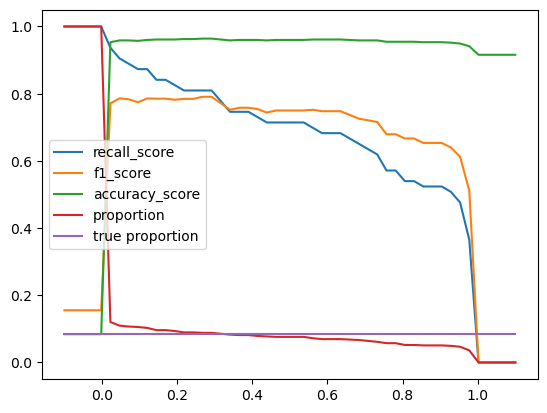

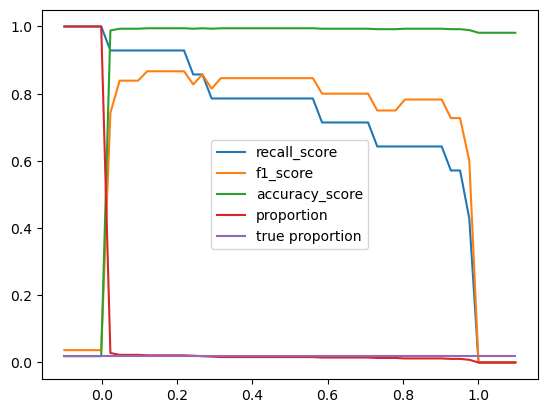

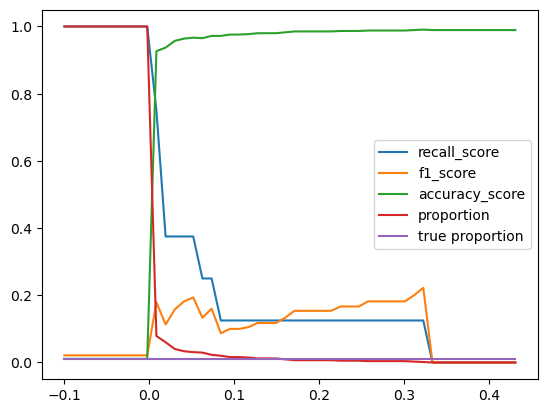

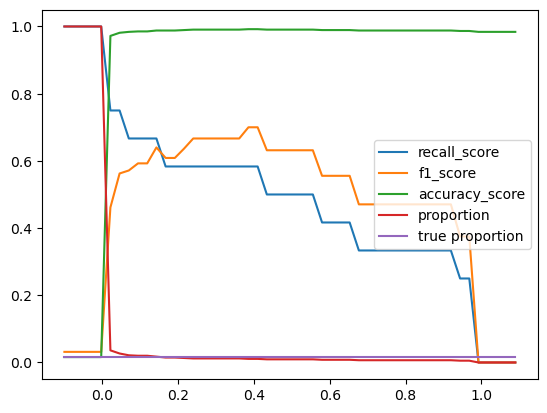

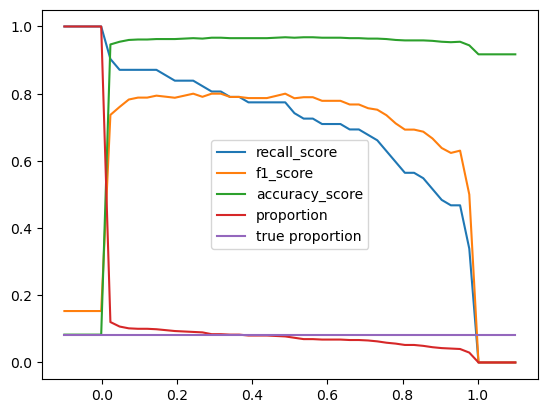

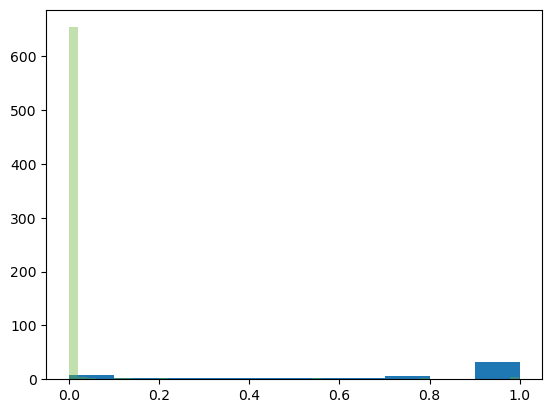

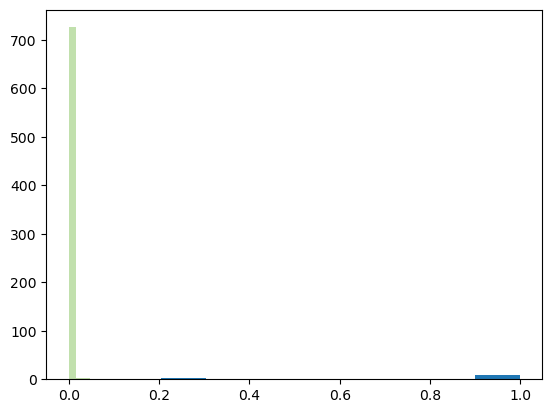

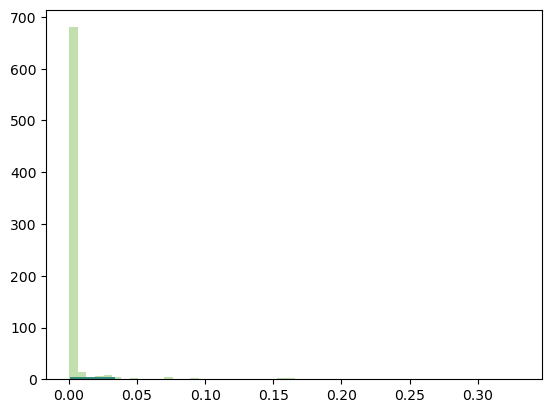

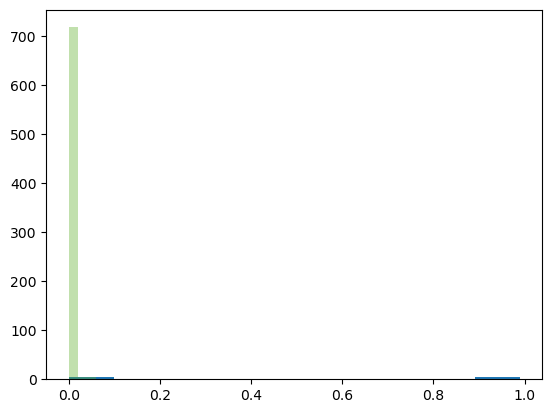

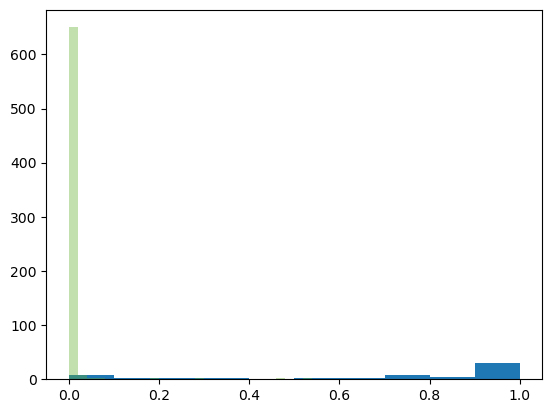

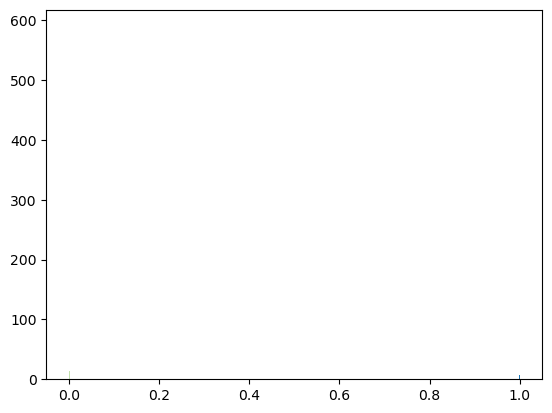

In [ ]:
model = GRUMultiModal(embeddings_dim = 768, audio_input_dim=23, audio_hidden_dim=16, audio_hidden_dim2=8, audio_layer_dim=3, video_input_dim=17, video_hidden_dim=16, video_hidden_dim2=10, video_layer_dim=3, output_dim=6, dropout_prob=.1)
model.load_state_dict(torch.load("models/GRU_concat_test"))

fin_targets = []
fin_outputs = []


with torch.no_grad():
    for j, batch in tqdm(enumerate(test_loader_1)):
        features_of, features_os, embeds, targets = batch['features_of'], batch['features_os'], batch['embeds'], batch['targets']
        pred = model(embeds, features_os, features_of)
        fin_targets.extend(targets.cpu().detach().numpy().tolist())
        fin_outputs.extend(np.array(pred.cpu().detach().numpy()).tolist())

    for j, batch in tqdm(enumerate(test_loader_2)):
        features_of, features_os, embeds, targets = batch['features_of'], batch['features_os'], batch['embeds'], batch['targets']
        pred = model(embeds, features_os, features_of)
        fin_targets.extend(targets.cpu().detach().numpy().tolist())
        fin_outputs.extend(np.array(pred.cpu().detach().numpy()).tolist())

y_true = np.asarray(fin_targets)
pred_n = np.asarray(fin_outputs)

def explore_tresh(true, pred):
    tresh = np.linspace(pred.min()-.1,pred.max()+.1,50)
    out = [(
        # precision_score(true, np.where(pred>t,1,0)),
        recall_score(true, np.where(pred>t,1,0)),
        f1_score(true, np.where(pred>t,1,0)),
        accuracy_score(true, np.where(pred>t, 1, 0)),
        np.where(pred>t,1,0).sum() / pred.shape[0],
        true.sum()/true.shape[0]
    ) for t in tresh]
    out = pd.DataFrame(out, columns=['recall_score', 'f1_score', 'accuracy_score', 'proportion', 'true proportion'], index=tresh) #'precision_score',
    return out

df_pred = pd.DataFrame(pred_n, columns = ['SD', 'QE', 'SV', 'PR', 'HD', "None"])
df_true = pd.DataFrame(y_true, columns = ['SD', 'QE', 'SV', 'PR', 'HD', "None"])
for i in range(5):
    explore_tresh(y_true[:,i], pred_n[:,i]).plot()

plt.figure()
plt.hist(df_pred.SD.loc[df_true.SD==1])
plt.hist(df_pred.SD.loc[df_true.SD==0], bins = 50, fc = (.4, .7, .2, .4))
plt.show()
plt.hist(df_pred.QE.loc[df_true.QE==1])
plt.hist(df_pred.QE.loc[df_true.QE==0], bins = 50, fc = (.4, .7, .2, .4))
plt.show()
plt.hist(df_pred.SV.loc[df_true.SV==1])
plt.hist(df_pred.SV.loc[df_true.SV==0], bins = 50, fc = (.4, .7, .2, .4))
plt.show()
plt.hist(df_pred.PR.loc[df_true.PR==1])
plt.hist(df_pred.PR.loc[df_true.PR==0], bins = 50, fc = (.4, .7, .2, .4))
plt.show()
plt.hist(df_pred.HD.loc[df_true.HD==1])
plt.hist(df_pred.HD.loc[df_true.HD==0], bins = 50, fc = (.4, .7, .2, .4))
plt.show()
plt.hist(df_pred.N.loc[df_true.N==1])
plt.hist(df_pred.N.loc[df_true.N==0], bins = 50, fc = (.4, .7, .2, .4))
plt.show()